In [3]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit, isnan, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [4]:
spark = SparkSession.builder.appName('accident_prediction').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('./UK_Accident.csv',header = 'True',inferSchema='True')

In [5]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: double (nullable = true)
 |-- Location_Northing_OSGR: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Numbe

In [6]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show(truncate=False)

+---+--------------+---------------------+----------------------+---------+--------+------------+-----------------+------------------+--------------------+----+-----------+----+--------------------------+-------------------------+--------------+---------------+---------+-----------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+
|_c0|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude|Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Date|Day_of_Week|Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|Road_Type|Speed_limit|Junction_Control|2nd_Road_Class|2nd_Road_Number|Pedestrian_Crossing-Human_Control|Pedestrian_Crossing-Physica

In [7]:
fin_df = df

fin_df.na.fill(value='Unknown',subset=["Weather_Conditions"])
fin_df.na.fill(value='Normal',subset=["Road_Surface_Conditions"])
fin_df.na.fill(value= 0 ,subset=["Latitude"])
fin_df.na.fill(value='None',subset=["Special_Conditions_at_Site"])
fin_df.na.fill(value='None',subset=["Carriageway_Hazards"])
fin_df.na.fill(value='No',subset=["Did_Police_Officer_Attend_Scene_of_Accident"])
fin_df.na.fill(value='None',subset=["Junction_Control"])
fin_df.na.fill(value='0',subset=["Location_Easting_OSGR"])

DataFrame[_c0: int, Accident_Index: string, Location_Easting_OSGR: double, Location_Northing_OSGR: double, Longitude: double, Latitude: double, Police_Force: int, Accident_Severity: int, Number_of_Vehicles: int, Number_of_Casualties: int, Date: string, Day_of_Week: int, Time: string, Local_Authority_(District): int, Local_Authority_(Highway): string, 1st_Road_Class: int, 1st_Road_Number: int, Road_Type: string, Speed_limit: int, Junction_Control: string, 2nd_Road_Class: int, 2nd_Road_Number: int, Pedestrian_Crossing-Human_Control: string, Pedestrian_Crossing-Physical_Facilities: string, Light_Conditions: string, Weather_Conditions: string, Road_Surface_Conditions: string, Special_Conditions_at_Site: string, Carriageway_Hazards: string, Urban_or_Rural_Area: int, Did_Police_Officer_Attend_Scene_of_Accident: string, LSOA_of_Accident_Location: string, Year: int]

In [8]:
fin_df = fin_df.dropna()

In [9]:
fin_df.select('Year').distinct().collect()

[Row(Year=2005),
 Row(Year=2006),
 Row(Year=2007),
 Row(Year=2009),
 Row(Year=2010),
 Row(Year=2011),
 Row(Year=2012),
 Row(Year=2013),
 Row(Year=2014)]

In [10]:
fin_df.groupBy("Year").sum("Number_of_Casualties").show(truncate=False)
fin_df.groupBy("Year").sum("Accident_Severity").show(truncate=False)
fin_df.groupBy("Year").sum("Number_of_Vehicles").show(truncate=False)


+----+-------------------------+
|Year|sum(Number_of_Casualties)|
+----+-------------------------+
|2005|252941                   |
|2006|241218                   |
|2007|219129                   |
|2009|206864                   |
|2010|195298                   |
|2011|191176                   |
|2012|229374                   |
|2013|171106                   |
|2014|182572                   |
+----+-------------------------+

+----+----------------------+
|Year|sum(Accident_Severity)|
+----+----------------------+
|2005|527311                |
|2006|500366                |
|2007|457642                |
|2009|431754                |
|2010|410504                |
|2011|401934                |
|2012|481585                |
|2013|365701                |
|2014|389048                |
+----+----------------------+

+----+-----------------------+
|Year|sum(Number_of_Vehicles)|
+----+-----------------------+
|2005|343428                 |
|2006|326220                 |
|2007|298288            

In [11]:
Lats = [row[0] for row in df.select('Latitude').collect()]

In [12]:
Lats

[51.489096,
 51.520075,
 51.525301,
 51.482442,
 51.495752,
 51.51554,
 51.512695,
 51.50226,
 51.48342,
 51.512443,
 51.494902,
 51.484044,
 51.491632,
 51.492622,
 51.495429,
 51.481912,
 51.500191,
 51.495811,
 51.486552,
 51.495498,
 51.492992,
 51.513039,
 51.482076,
 51.49296,
 51.498062,
 51.508265,
 51.513988,
 51.488671,
 51.494902,
 51.496893,
 51.517796,
 51.521988,
 51.497103,
 51.519986,
 51.523585,
 51.514951,
 51.478096,
 51.481804,
 51.492652,
 51.500648,
 51.509377,
 51.483999,
 51.509154,
 51.488776,
 51.502177,
 51.4849,
 51.495806,
 51.485005,
 51.485515,
 51.492515,
 51.509515,
 51.493527,
 51.521709,
 51.481575,
 51.516656,
 51.501941,
 51.497911,
 51.518806,
 51.49724,
 51.506807,
 51.481822,
 51.49164,
 51.494121,
 51.501596,
 51.494146,
 51.491273,
 51.481575,
 51.487215,
 51.508707,
 51.495084,
 51.482582,
 51.486931,
 51.509125,
 51.493285,
 51.499569,
 51.49369,
 51.490178,
 51.494981,
 51.514966,
 51.493429,
 51.50134,
 51.4829,
 51.481989,
 51.481746,
 51.

In [13]:
df.select('Year').distinct().collect()

[Row(Year=2005),
 Row(Year=2006),
 Row(Year=2007),
 Row(Year=2009),
 Row(Year=2010),
 Row(Year=2011),
 Row(Year=2012),
 Row(Year=2013),
 Row(Year=2014)]

In [14]:
fin_df = df.drop('Junction Detail')

In [15]:
fin_df.groupBy("Year").sum("Number_of_Casualties").show(truncate=False)
fin_df.groupBy("Year").sum("Accident_Severity").show(truncate=False)
fin_df.groupBy("Year").sum("Number_of_Vehicles").show(truncate=False)

## Visualize with Tableau, to use for project reference

+----+-------------------------+
|Year|sum(Number_of_Casualties)|
+----+-------------------------+
|2005|271017                   |
|2006|258404                   |
|2007|247780                   |
|2009|222146                   |
|2010|208648                   |
|2011|203950                   |
|2012|241954                   |
|2013|183670                   |
|2014|194477                   |
+----+-------------------------+

+----+----------------------+
|Year|sum(Accident_Severity)|
+----+----------------------+
|2005|565350                |
|2006|536685                |
|2007|516595                |
|2009|464551                |
|2010|439340                |
|2011|429842                |
|2012|508587                |
|2013|393140                |
|2014|414974                |
+----+----------------------+

+----+-----------------------+
|Year|sum(Number_of_Vehicles)|
+----+-----------------------+
|2005|366236                 |
|2006|348059                 |
|2007|334966            

In [16]:
fin_df.groupBy("Road_Type").sum("Number_of_Casualties").show(truncate=False)
fin_df.groupBy("Road_Type").sum("Accident_Severity").show(truncate=False)


##Visualize with Tableau

+------------------+-------------------------+
|Road_Type         |sum(Number_of_Casualties)|
+------------------+-------------------------+
|Slip road         |22211                    |
|One way street    |36951                    |
|Unknown           |10394                    |
|Roundabout        |126656                   |
|Single carriageway|1506994                  |
|Dual carriageway  |328840                   |
+------------------+-------------------------+

+------------------+----------------------+
|Road_Type         |sum(Accident_Severity)|
+------------------+----------------------+
|Slip road         |45366                 |
|One way street    |88648                 |
|Unknown           |24037                 |
|Roundabout        |291935                |
|Single carriageway|3188104               |
|Dual carriageway  |630974                |
+------------------+----------------------+



In [17]:
df_2005 = df.filter(df.Year == 2005).show(truncate=False)


#fin_df.groupBy("").sum("Number_of_Casualties").show(truncate=False)

+---+--------------+---------------------+----------------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-----+--------------------------+-------------------------+--------------+---------------+------------------+-----------+------------------------+--------------+---------------+---------------------------------+-------------------------------------------+---------------------------------------+--------------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+
|_c0|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude|Latitude |Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|Date      |Day_of_Week|Time |Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|Road_Type         |Speed_limit|Junction_Control        |2nd_Roa

In [18]:
# ## casualties based on speed limit

# fin_df.filter( (df.Speed_limit == "OH") & (df.gender  == "M") ).groupBy.

In [19]:
acc_per_week = fin_df.groupBy("Day_of_Week").sum("Number_of_Casualties")


In [20]:
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

In [21]:
cas_count = fin_df.select(col("Number_of_Casualties"),col("Day_of_Week"),col("Speed_Limit")).show()



#visualize based on speed limit

+--------------------+-----------+-----------+
|Number_of_Casualties|Day_of_Week|Speed_Limit|
+--------------------+-----------+-----------+
|                   1|          3|         30|
|                   1|          4|         30|
|                   1|          5|         30|
|                   1|          6|         30|
|                   1|          2|         30|
|                   1|          3|         30|
|                   1|          5|         30|
|                   2|          6|         30|
|                   2|          7|         30|
|                   5|          7|         30|
|                   1|          1|         30|
|                   1|          3|         30|
|                   1|          3|         30|
|                   1|          3|         30|
|                   2|          3|         30|
|                   1|          3|         30|
|                   1|          5|         30|
|                   1|          6|         30|
|            

In [22]:
pip install -U pandasql

In [91]:
#Accident Severity
sev_acc = fin_df.select(col('Accident_Index'), col("Accident_Severity"),col("Day_of_Week"),col("Road_Surface_Conditions"),col("Light_Conditions"), col("Weather_Conditions"), col('Number_of_Casualties'), col("Date"), col("Road_Type"), col('LSOA_of_Accident_Location'))
acc_sev = fin_df.select(col("Accident_Severity"),col("Day_of_Week"),col("Road_Surface_Conditions"),col("Light_Conditions"), col("Weather_Conditions"), col('Number_of_Casualties'), col("Road_Type"), col("Number_of_vehicles"))

In [24]:
print(acc_sev.describe(),'\n')

DataFrame[summary: string, Accident_Severity: string, Day_of_Week: string, Road_Surface_Conditions: string, Light_Conditions: string, Weather_Conditions: string, Number_of_Casualties: string] 



In [92]:
bindexer = StringIndexer(inputCols=["Road_Surface_Conditions", "Light_Conditions", "Weather_Conditions", "Road_Type"],
                               outputCols=["Road_Conditions_indexed","Light_Conditions_indexed","Weather_Conditions_indexed", "Road_Type_indexed"])
bindexed = bindexer.fit(acc_sev).transform(acc_sev).drop( "Road_Surface_Conditions", "Light_Conditions", "Weather_Conditions", "Road_Type")

# acc_sev.sample()
bindexed.show()
# acc_sev = fin_df.select(col("Accident_Severity"),col("Day_of_Week"),col("Road_Surface_Conditions"),col("Light_Conditions"), col("Weather_Conditions"), col('Number_of_Casualties')).toPandas()



+-----------------+-----------+--------------------+------------------+-----------------------+------------------------+--------------------------+-----------------+
|Accident_Severity|Day_of_Week|Number_of_Casualties|Number_of_vehicles|Road_Conditions_indexed|Light_Conditions_indexed|Weather_Conditions_indexed|Road_Type_indexed|
+-----------------+-----------+--------------------+------------------+-----------------------+------------------------+--------------------------+-----------------+
|                2|          3|                   1|                 1|                    1.0|                     0.0|                       1.0|              0.0|
|                3|          4|                   1|                 1|                    0.0|                     1.0|                       0.0|              1.0|
|                3|          5|                   1|                 2|                    0.0|                     1.0|                       0.0|              0.0|
|   

In [27]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [94]:

# convert to vector column first
vector_col = "features"
assembler = VectorAssembler(inputCols= ["Day_of_Week", 'Number_of_Casualties', 'Road_Conditions_indexed',
 'Light_Conditions_indexed', 'Weather_Conditions_indexed', "Road_Type_indexed", "Number_of_vehicles"], outputCol='features')
df_vector = assembler.transform(bindexed).select(vector_col,'Accident_Severity')  

matrix = Correlation.corr(df_vector, vector_col)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [95]:
cor_matrix = matrix.collect()[0]["pearson({})".format(vector_col)].values
cor_matrix

array([ 1.00000000e+00, -1.45537848e-03, -7.22898548e-03,  6.60441763e-03,
       -1.31473970e-03, -3.20969250e-03, -1.15592868e-04, -1.45537848e-03,
        1.00000000e+00,  2.73605806e-02,  3.48066501e-02,  6.64181681e-03,
       -3.56206807e-03,  2.37349074e-01, -7.22898548e-03,  2.73605806e-02,
        1.00000000e+00,  1.70739062e-01,  4.34463601e-01, -1.69841352e-02,
       -3.49999839e-02,  6.60441763e-03,  3.48066501e-02,  1.70739062e-01,
        1.00000000e+00,  1.24182443e-01, -5.29098667e-03, -8.00480760e-02,
       -1.31473970e-03,  6.64181681e-03,  4.34463601e-01,  1.24182443e-01,
        1.00000000e+00,  1.09036902e-02, -2.09895382e-02, -3.20969250e-03,
       -3.56206807e-03, -1.69841352e-02, -5.29098667e-03,  1.09036902e-02,
        1.00000000e+00,  3.51553141e-02, -1.15592868e-04,  2.37349074e-01,
       -3.49999839e-02, -8.00480760e-02, -2.09895382e-02,  3.51553141e-02,
        1.00000000e+00])

In [96]:
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
cor_np

array([[ 1.00000000e+00, -1.45537848e-03, -7.22898548e-03,
         6.60441763e-03, -1.31473970e-03, -3.20969250e-03,
        -1.15592868e-04],
       [-1.45537848e-03,  1.00000000e+00,  2.73605806e-02,
         3.48066501e-02,  6.64181681e-03, -3.56206807e-03,
         2.37349074e-01],
       [-7.22898548e-03,  2.73605806e-02,  1.00000000e+00,
         1.70739062e-01,  4.34463601e-01, -1.69841352e-02,
        -3.49999839e-02],
       [ 6.60441763e-03,  3.48066501e-02,  1.70739062e-01,
         1.00000000e+00,  1.24182443e-01, -5.29098667e-03,
        -8.00480760e-02],
       [-1.31473970e-03,  6.64181681e-03,  4.34463601e-01,
         1.24182443e-01,  1.00000000e+00,  1.09036902e-02,
        -2.09895382e-02],
       [-3.20969250e-03, -3.56206807e-03, -1.69841352e-02,
        -5.29098667e-03,  1.09036902e-02,  1.00000000e+00,
         3.51553141e-02],
       [-1.15592868e-04,  2.37349074e-01, -3.49999839e-02,
        -8.00480760e-02, -2.09895382e-02,  3.51553141e-02,
         1.0000000

In [97]:
df_vector.show()

+--------------------+-----------------+
|            features|Accident_Severity|
+--------------------+-----------------+
|[3.0,1.0,1.0,0.0,...|                2|
|[4.0,1.0,0.0,1.0,...|                3|
|[5.0,1.0,0.0,1.0,...|                3|
|(7,[0,1,6],[6.0,1...|                3|
|[2.0,1.0,1.0,3.0,...|                3|
|[3.0,1.0,1.0,0.0,...|                3|
|[5.0,1.0,0.0,1.0,...|                3|
|[6.0,2.0,0.0,0.0,...|                3|
|[7.0,2.0,0.0,1.0,...|                3|
|(7,[0,1,6],[7.0,5...|                3|
|[1.0,1.0,0.0,1.0,...|                3|
|[3.0,1.0,1.0,1.0,...|                3|
|[3.0,1.0,1.0,0.0,...|                3|
|[3.0,1.0,1.0,1.0,...|                3|
|[3.0,2.0,0.0,0.0,...|                3|
|(7,[0,1,6],[3.0,1...|                3|
|[5.0,1.0,0.0,1.0,...|                2|
|(7,[0,1,6],[6.0,1...|                3|
|[6.0,1.0,0.0,1.0,...|                3|
|[7.0,1.0,0.0,1.0,...|                2|
+--------------------+-----------------+
only showing top

In [98]:
cols = bindexed.columns
cols

['Accident_Severity',
 'Day_of_Week',
 'Number_of_Casualties',
 'Number_of_vehicles',
 'Road_Conditions_indexed',
 'Light_Conditions_indexed',
 'Weather_Conditions_indexed',
 'Road_Type_indexed']

C:\Users\HP\AppData\Local\Temp\ipykernel_20520\1290264614.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
C:\Users\HP\AppData\Local\Temp\ipykernel_20520\1290264614.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


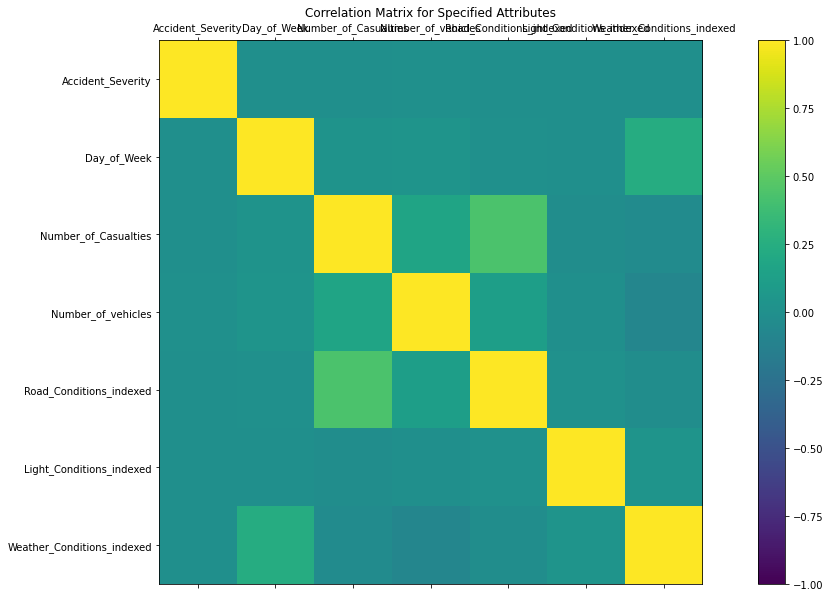

In [99]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.show()

plot_corr_matrix(cor_np, cols, 234)

In [101]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

r = ChiSquareTest.test(df_vector, "features", "Accident_Severity").head()



print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


pValues: [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
degreesOfFreedom: [12, 92, 10, 8, 16, 10, 52]
statistics: [2639.459795097584,14299.744114717878,522.2762898287489,10446.739170456356,1696.9419422575206,4986.629696888286,25126.481193806536]


In [47]:
indexer = StringIndexer(inputCols=["Road_Surface_Conditions","Weather_Conditions", "Road_Type",'LSOA_of_Accident_Location'],
                               outputCols=["Road_Conditions_indexed","Weather_Conditions_indexed", "Road_Type_indexed", 'LSOA_of_Accident_Location_indexed'])
indexed = indexer.fit(sev_acc).transform(sev_acc).drop("Accident_Index","Road_Surface_Conditions", "Weather_Conditions", "Road_Type",'LSOA_of_Accident_Location', "Date", "Light_Conditions")

# acc_sev.sample()
indexed.show()

+-----------------+-----------+--------------------+-----------------------+--------------------------+-----------------+---------------------------------+
|Accident_Severity|Day_of_Week|Number_of_Casualties|Road_Conditions_indexed|Weather_Conditions_indexed|Road_Type_indexed|LSOA_of_Accident_Location_indexed|
+-----------------+-----------+--------------------+-----------------------+--------------------------+-----------------+---------------------------------+
|                2|          3|                   1|                    1.0|                       1.0|              0.0|                           6788.0|
|                3|          4|                   1|                    0.0|                       0.0|              1.0|                           7783.0|
|                3|          5|                   1|                    0.0|                       0.0|              0.0|                          33088.0|
|                3|          6|                   1|            

In [79]:
vector_col2 = "features2"
assembler2 = VectorAssembler(inputCols= ["Number_of_Casualties", "Day_of_Week", "Road_Conditions_indexed","Weather_Conditions_indexed", "Road_Type_indexed", 'LSOA_of_Accident_Location_indexed'], outputCol='features2')
df_vector2 = assembler2.transform(indexed).select(vector_col2, "Accident_Severity")
df_vector2.show()

+--------------------+-----------------+
|           features2|Accident_Severity|
+--------------------+-----------------+
|[1.0,3.0,1.0,1.0,...|                2|
|[1.0,4.0,0.0,0.0,...|                3|
|[1.0,5.0,0.0,0.0,...|                3|
|[1.0,6.0,0.0,0.0,...|                3|
|[1.0,2.0,1.0,0.0,...|                3|
|[1.0,3.0,1.0,1.0,...|                3|
|[1.0,5.0,0.0,0.0,...|                3|
|[2.0,6.0,0.0,0.0,...|                3|
|[2.0,7.0,0.0,0.0,...|                3|
|[5.0,7.0,0.0,0.0,...|                3|
|[1.0,1.0,0.0,0.0,...|                3|
|[1.0,3.0,1.0,0.0,...|                3|
|[1.0,3.0,1.0,1.0,...|                3|
|[1.0,3.0,1.0,1.0,...|                3|
|[2.0,3.0,0.0,0.0,...|                3|
|[1.0,3.0,0.0,0.0,...|                3|
|[1.0,5.0,0.0,0.0,...|                2|
|[1.0,6.0,0.0,0.0,...|                3|
|[1.0,6.0,0.0,0.0,...|                3|
|[1.0,7.0,0.0,0.0,...|                2|
+--------------------+-----------------+
only showing top

In [81]:
cols2 = indexed.columns
cols2

['Accident_Severity',
 'Day_of_Week',
 'Number_of_Casualties',
 'Road_Conditions_indexed',
 'Weather_Conditions_indexed',
 'Road_Type_indexed',
 'LSOA_of_Accident_Location_indexed']

In [74]:
train, test = bindexed.randomSplit([0.75,0.25])
from pyspark.ml.recommendation import ALS

#Training the accident_prediction model using train datatset
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='Day_of_Week'
        ,itemCol='Accident_Severity'
        ,ratingCol='Number_of_Casualties'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#fit the model on train set
rec_model=rec.fit(train)

#making predictions on test set 
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).show()

+-----------------+-----------+--------------------+-----------------------+------------------------+--------------------------+----------+
|Accident_Severity|Day_of_Week|Number_of_Casualties|Road_Conditions_indexed|Light_Conditions_indexed|Weather_Conditions_indexed|prediction|
+-----------------+-----------+--------------------+-----------------------+------------------------+--------------------------+----------+
|                1|          1|                   1|                    0.0|                     0.0|                       0.0| 1.9866593|
|                1|          1|                   1|                    0.0|                     0.0|                       0.0| 1.9866593|
|                1|          1|                   1|                    0.0|                     0.0|                       0.0| 1.9866593|
|                1|          1|                   1|                    0.0|                     0.0|                       0.0| 1.9866593|
|                1| 

In [102]:
from pyspark.ml.evaluation import RegressionEvaluator
# create Regressor evaluator object for measuring accuracy
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='Accident_Severity')
# apply the RE on predictions dataframe to calculate RMSE
rmse=evaluator.evaluate(predicted_ratings)
# print RMSE error
print(rmse)

1.564905762320358


In [ ]:
training_df,test_df= df_vector.randomSplit([0.75,0.25])

#import the logistic regression 
from pyspark.ml.classification import LogisticRegression

#Apply the logistic regression model
log_reg=LogisticRegression(labelCol='Accident_Severity').fit(training_df)

#Training Results
train_results=log_reg.evaluate(training_df).predictions
train_results.filter(train_results['Accident_Severity']==1).filter(train_results['prediction']==1).select(['Accident_Severity','prediction','probability']).show(10,False)

+-----------------+----------+-------------------------------------------------------------------------------------+
|Accident_Severity|prediction|probability                                                                          |
+-----------------+----------+-------------------------------------------------------------------------------------+
|1                |1.0       |[2.720216533425166E-6,0.387403320028815,0.32962167652503777,0.28297228322961365]     |
|1                |1.0       |[2.3752413809539555E-6,0.5603736515150288,0.28924645865847476,0.1503775145851153]    |
|1                |1.0       |[2.7076839770616413E-6,0.40450144017037615,0.3195403803675688,0.27595547177807794]   |
|1                |1.0       |[2.674217314460933E-6,0.4179760542685491,0.3380571324070955,0.2439641391070411]      |
|1                |1.0       |[1.5245088415894914E-8,0.9985361221020082,0.0014587720141729767,5.090638730539173E-6]|
|1                |1.0       |[2.711094628029024E-6,0.3755660593

In [ ]:

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Accident_Severity',metricName='accuracy').evaluate(train_results))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Accident_Severity',metricName='weightedPrecision').evaluate(train_results))

Accuracy:  0.8535078459003081
Precision:  0.7602172790517319


In [ ]:
from pyspark.ml.feature import OneHotEncoder

stage_1 = StringIndexer(inputCol= 'Accident_Severity', outputCol= 'category_1_index')
# define stage 2 : transform the column category_2 to numeric
stage_2 = StringIndexer(inputCol= 'Number_of_Casualties', outputCol= 'category_2_index')
# define stage 3 : one hot encode the numeric category_2 column
stage_3 = OneHotEncoder(inputCols=['category_2_index'], outputCols=['category_2_OHE'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(fin_df)
sample_df_updated = pipeline_model.transform(fin_df)

# view the transformed data
sample_df_updated.show()

+---+--------------+---------------------+----------------------+---------+---------+------------+-----------------+------------------+--------------------+----------+-----------+-----+--------------------------+-------------------------+--------------+---------------+------------------+-----------+--------------------+--------------+---------------+---------------------------------+---------------------------------------+--------------------+--------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+----+----------------+----------------+--------------+
|_c0|Accident_Index|Location_Easting_OSGR|Location_Northing_OSGR|Longitude| Latitude|Police_Force|Accident_Severity|Number_of_Vehicles|Number_of_Casualties|      Date|Day_of_Week| Time|Local_Authority_(District)|Local_Authority_(Highway)|1st_Road_Class|1st_Road_Number|         Road_Type|Speed_limit|    Junction_Con